In [1]:
from src.datasets.nli import *
from src.model.nli_models import *
from src.utils.nli_utils import *

In [2]:
snli_conf = {"batch_size":128,"max_len":50,"device":'cuda',"tokenizer":'spacy',"use_char_emb":False,"max_word_len":10}
dataset = snli_module(snli_conf)

In [3]:
dataset.prepare_data()

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class MwAN_Encoder(nn.Module):
    def __init__(self,conf):
        super().__init__()
        self.dropout = nn.Dropout(conf["dropout"])
        self.embedding = nn.Embedding(
            num_embeddings=conf["vocab_size"],
            embedding_dim=conf["embedding_dim"],
            padding_idx=conf["padding_idx"],
        )
        
        if conf["use_glove"]:
            self.embedding = nn.Embedding.from_pretrained(
                torch.load(".vector_cache/{}_vectors.pt".format(conf["dataset"]))
            )

        if conf["use_char_emb"]:
            self.char_embedding = nn.Embedding(
                num_embeddings=conf["char_vocab_size"],
                embedding_dim=conf["char_embedding_dim"],
                padding_idx=0,
            )
            self.char_cnn = nn.Conv2d(
                conf["max_word_len"],
                conf["char_embedding_dim"],
                (1, 6),
                stride=(1, 1),
                padding=0,
                bias=True,
            )

        self.projection = nn.Linear(
            (
                conf["embedding_dim"]
                + int(conf["use_char_emb"]) * conf["char_embedding_dim"]
            ),
            conf["hidden_size"],
        )

        self.gru = nn.GRU(
            input_size=conf["hidden_size"],
            hidden_size=conf["hidden_size"],
            batch_first=True,
            bidirectional=True,
        )

    def char_embedding_forward(self, x):
        # X - [batch_size, seq_len, char_emb_size])
        batch_size, seq_len, char_emb_size = x.shape
        x = x.view(-1, char_emb_size)
        x = self.char_embedding(x)  # (batch_size * seq_len, char_emb_size, emb_size)
        x = x.view(batch_size, -1, seq_len, char_emb_size)
        x = x.permute(0, 3, 2, 1)
        x = self.char_cnn(x)
        x = torch.max(F.relu(x), 3)[0]
        return x.view(batch_size, seq_len, -1)

    def forward(self, inp, char_vec):
        embedded = self.embedding(inp)
        if char_vec != None:
            char_emb = self.char_embedding_forward(char_vec)
            embedded = torch.cat([embedded, char_emb], dim=2)
        embedded = self.dropout(self.projection(embedded))
        all_, _ = self.gru(embedded)
        return all_

class MwAN(nn.Module):
    def __init__(self, conf):
        super().__init__()
        self.dropout = nn.Dropout(conf["dropout"])

        
        self.embedding = nn.Embedding(
            num_embeddings=conf["vocab_size"],
            embedding_dim=conf["embedding_dim"],
            padding_idx=conf["padding_idx"],
        )
        
        if conf["use_glove"]:
            self.embedding = nn.Embedding.from_pretrained(
                torch.load(".vector_cache/{}_vectors.pt".format(conf["dataset"]))
            )

        if conf["use_char_emb"]:
            self.char_embedding = nn.Embedding(
                num_embeddings=conf["char_vocab_size"],
                embedding_dim=conf["char_embedding_dim"],
                padding_idx=0,
            )
            self.char_cnn = nn.Conv2d(
                conf["max_word_len"],
                conf["char_embedding_dim"],
                (1, 6),
                stride=(1, 1),
                padding=0,
                bias=True,
            )

        

        self.prem_gru = nn.GRU(
            input_size=(
                conf["embedding_dim"]
                + int(conf["use_char_emb"]) * conf["char_embedding_dim"]
            ),
            hidden_size=conf["hidden_size"],
            batch_first=True,
            bidirectional=True,
        )

        self.hypo_gru = nn.GRU(
            input_size=(
                conf["embedding_dim"]
                + int(conf["use_char_emb"]) * conf["char_embedding_dim"]
            ),
            hidden_size=conf["hidden_size"],
            batch_first=True,
            bidirectional=True,
        )

        # Concat Attention
        self.Wc1 = nn.Linear(2 * conf["hidden_size"], conf["hidden_size"], bias=False)
        self.Wc2 = nn.Linear(2 * conf["hidden_size"], conf["hidden_size"], bias=False)
        self.vc = nn.Linear(conf["hidden_size"], 1, bias=False)
        # Bilinear Attention
        self.Wb = nn.Linear(
            2 * conf["hidden_size"], 2 * conf["hidden_size"], bias=False
        )
        # Dot Attention :
        self.Wd = nn.Linear(2 * conf["hidden_size"], conf["hidden_size"], bias=False)
        self.vd = nn.Linear(conf["hidden_size"], 1, bias=False)
        # Minus Attention :
        self.Wm = nn.Linear(2 * conf["hidden_size"], conf["hidden_size"], bias=False)
        self.vm = nn.Linear(conf["hidden_size"], 1, bias=False)

        self.Ws = nn.Linear(2 * conf["hidden_size"], conf["hidden_size"], bias=False)
        self.vs = nn.Linear(conf["hidden_size"], 1, bias=False)

        self.gru_agg = nn.GRU(
            12 * conf["hidden_size"],
            conf["hidden_size"],
            batch_first=True,
            bidirectional=True,
        )

        self.Wq = nn.Linear(2 * conf["hidden_size"], conf["hidden_size"], bias=False)
        self.vq = nn.Linear(conf["hidden_size"], 1, bias=False)
        self.Wp1 = nn.Linear(2 * conf["hidden_size"], conf["hidden_size"], bias=False)
        self.Wp2 = nn.Linear(2 * conf["hidden_size"], conf["hidden_size"], bias=False)
        self.vp = nn.Linear(conf["hidden_size"], 1, bias=False)

        self.prediction = nn.Linear(2 * conf["hidden_size"], 3, bias=False)


    def char_embedding_forward(self, x):
        # X - [batch_size, seq_len, char_emb_size])
        batch_size, seq_len, char_emb_size = x.shape
        x = x.view(-1, char_emb_size)
        x = self.char_embedding(x)  # (batch_size * seq_len, char_emb_size, emb_size)
        x = x.view(batch_size, -1, seq_len, char_emb_size)
        x = x.permute(0, 3, 2, 1)
        x = self.char_cnn(x)
        x = torch.max(F.relu(x), 3)[0]
        return x.view(batch_size, seq_len, -1)

    def forward(self, inputs):
        
        premise = inputs[0]
        hypothesis = inputs[1]

        if len(inputs) == 4:
            char_vec_x0 = inputs[2]
            char_vec_x1 = inputs[3]
        else:
            char_vec_x0 = None
            char_vec_x1 = None

        hp = self.embedding(premise)
        hh = self.embedding(hypothesis)

        if char_vec_x0 != None:
            char_emb_hp = self.char_embedding_forward(char_vec_x0)
            hp = torch.cat([hp, char_emb_hp], dim=2)

        if char_vec_x1 != None:
            char_emb_hh = self.char_embedding_forward(char_vec_x1)
            hh = torch.cat([hh, char_emb_hh], dim=2)

        hp,_ = self.prem_gru(hp)
        hh,_ = self.hypo_gru(hh)


        _s1 = self.Wc1(hp).unsqueeze(1)

        _s2 = self.Wc2(hh).unsqueeze(2)

        sjt = self.vc(torch.tanh(_s1 + _s2)).squeeze()

        ait = F.softmax(sjt, 2)

        qtc = ait.bmm(hp)
        _s1 = self.Wb(hp).transpose(2, 1)
        sjt = hh.bmm(_s1)
        ait = F.softmax(sjt, 2)
        qtb = ait.bmm(hp)
        _s1 = hp.unsqueeze(1)
        _s2 = hh.unsqueeze(2)
        sjt = self.vd(torch.tanh(self.Wd(_s1 * _s2))).squeeze()
        ait = F.softmax(sjt, 2)
        qtd = ait.bmm(hp)
        sjt = self.vm(torch.tanh(self.Wm(_s1 - _s2))).squeeze()
        ait = F.softmax(sjt, 2)
        qtm = ait.bmm(hp)
        _s1 = hh.unsqueeze(1)
        _s2 = hh.unsqueeze(2)
        sjt = self.vs(torch.tanh(self.Ws(_s1 * _s2))).squeeze()
        ait = F.softmax(sjt, 2)
        qts = ait.bmm(hh)
        aggregation = torch.cat([hh, qts, qtc, qtd, qtb, qtm], 2)
        aggregation_representation, _ = self.gru_agg(aggregation)
        sj = self.vq(torch.tanh(self.Wq(hp))).transpose(2, 1)
        rq = F.softmax(sj, 2).bmm(hp)
        sj = F.softmax(
            self.vp(self.Wp1(aggregation_representation) + self.Wp2(rq)).transpose(
                2, 1
            ),
            2,
        )
        rp = sj.bmm(aggregation_representation)
        encoder_output = self.dropout(F.leaky_relu(self.prediction(rp)))
        encoder_output = encoder_output.squeeze(1)
        return encoder_output


In [38]:
model_conf = {
    "hidden_size":200,
    "embedding_dim":300,
    "char_embedding_dim":100,
    "dropout":0.3,
    "use_glove":False,
    "num_layers":1,
    "dataset":"snli",
    "fcs":1,
    "use_char_emb":False,
    "vocab_size":dataset.vocab_size(),
    # "char_vocab_size":dataset.char_vocab_size(),
    # "max_word_len": dataset.char_word_len(),
    "tokenizer":"spacy",
    "padding_idx":dataset.padding_idx(),
    "attention_layer_param":200,
    # "r":3,
    # "gated_embedding_dim":150,
    # "pool_strategy":'max',
    # "gated":True
}

hparams = {
    "optimizer_base": {
        "optim": "adamw",
        "lr": 0.0010039910781394373,
        "scheduler": "const",
    },
    "optimizer_tune": {
        "optim": "adam",
        "lr": 0.0010039910781394373,
        "weight_decay": 0.1,
        "scheduler": "lambda",
    },
    "switch_epoch": 5,
}

model = MwAN(model_conf)
# model = SNLI_model(attn_bilstm_snli,model_conf,hparams=hparams)

In [39]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

15309800

In [40]:
train_dl,val_dl,test_dl = dataset.data.get_dataloaders()


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.11E-04


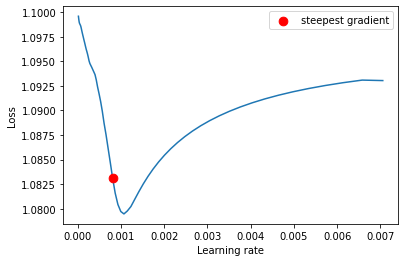

In [43]:
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dl, val_loader=val_dl, end_lr=0.01, num_iter=100, step_mode="exp")
lr_finder.plot(log_lr=False)
lr_finder.reset()

In [28]:
9.27E-04


[[tensor([[   2,    4,   46,  ...,    1,    1,    1],
        [   2,    4,   46,  ...,    1,    1,    1],
        [   2,    4,   46,  ...,    1,    1,    1],
        ...,
        [   2, 1518, 1134,  ...,    1,    1,    1],
        [   2,    6, 2169,  ...,    1,    1,    1],
        [   2,    6, 2169,  ...,    1,    1,    1]]), tensor([[ 2,  4, 46,  ...,  1,  1,  1],
        [ 2,  4, 46,  ...,  1,  1,  1],
        [ 2,  4, 46,  ...,  1,  1,  1],
        ...,
        [ 2,  4, 33,  ...,  1,  1,  1],
        [ 2,  4, 33,  ...,  1,  1,  1],
        [ 2,  4, 33,  ...,  1,  1,  1]])], tensor([2, 1, 0, 2, 0, 1, 1, 0, 2, 2, 1, 2, 2, 1, 0, 2, 1, 0, 0, 1, 2, 2, 1, 0,
        1, 0, 2, 2, 1, 0, 2, 0, 1, 1, 2, 0, 1, 0, 2, 2, 0, 1, 2, 0, 0, 0, 2, 1,
        1, 0, 2, 1, 0, 2, 1, 2, 0, 2, 1, 0, 0, 1, 2, 0, 2, 1, 1, 0, 2, 1, 0, 2,
        2, 1, 0, 2, 1, 0, 1, 0, 2, 2, 1, 0, 0, 1, 2, 1, 0, 2, 1, 0, 1, 2, 1, 2,
        0, 2, 2, 0, 2, 1, 1, 0, 0, 2, 0, 1, 1, 0, 2, 2, 0, 1, 1, 2, 0, 0, 2, 1,
        1, 2, 0

In [44]:
8.11E-04

0.000811

In [29]:
opt = model(i[0])

In [32]:
i[1]

tensor([2, 1, 0, 2, 0, 1, 1, 0, 2, 2, 1, 2, 2, 1, 0, 2, 1, 0, 0, 1, 2, 2, 1, 0,
        1, 0, 2, 2, 1, 0, 2, 0, 1, 1, 2, 0, 1, 0, 2, 2, 0, 1, 2, 0, 0, 0, 2, 1,
        1, 0, 2, 1, 0, 2, 1, 2, 0, 2, 1, 0, 0, 1, 2, 0, 2, 1, 1, 0, 2, 1, 0, 2,
        2, 1, 0, 2, 1, 0, 1, 0, 2, 2, 1, 0, 0, 1, 2, 1, 0, 2, 1, 0, 1, 2, 1, 2,
        0, 2, 2, 0, 2, 1, 1, 0, 0, 2, 0, 1, 1, 0, 2, 2, 0, 1, 1, 2, 0, 0, 2, 1,
        1, 2, 0, 1, 2, 0, 2, 0])

In [51]:
premise_len = [len(i.premise) for i in dataset.data.train.examples]

192